In [6]:
import numpy as np
from PIL import Image
from numpy import linalg as LA

def gaussian(k,mean = 0, std=1):
    if k%2==0:
        raise Exception('짝수 X')
    size = (k,k)
    gauss_filter = np.zeros(size)
    mid = (k-1)//2
    
    # mean = 0 이라 가정
    
    for i in range(k):
        for j in range(k):
            gauss_filter[i,j] = np.exp(-((((i-mid)**2) + ((j-mid)**2))/(2*(std**2))))
    K = gauss_filter.sum()
    
    return gauss_filter/K

def moravec(image):
    k=3
    weight = np.ones(shape=(k,k))
    threshold = 0.04
    original_img = np.array(image).astype('float32')
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
        weight = np.expand_dims(weight,2)
        
        
    height, width, channel = original_img.shape
    original_img = np.pad(original_img/255., (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    
    result_map = np.zeros(shape=(height,width,channel))
    for h in range((k-1)//2, height-(k-1)//2):
        for w in range((k-1)//2, width-(k-1)//2):
            for c in range(channel):
                candidate=[]
                dy = [0,0,-1,1]
                dx = [-1,1,0,0]
                for i in range(4):
                    
                    candidate.append((weight[:,:,c]*(original_img[h:h+k,w:w+k,c]-original_img[h+dy[i]:h+dy[i]+k ,w+dx[i]:w+dx[i]+k,c])**2).sum())
                
                #print(min(candidate))
                if min(candidate)>threshold:
                    result_map[h-(k-1)//2,w-(k-1)//2,c] = 255
                else:
                    result_map[h-(k-1)//2,w-(k-1)//2,c] = 0
                    
            #original_img[h-(k-1)//2 : h+(k-1)//2, h-(k-1)//2 : h+(k-1)//2]
    return result_map
    
    
def harris(image):
    k=3
    weight = gaussian(k=k)
    threshold = 0.9
    original_img = np.array(image).astype('float32')
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
        weight = np.expand_dims(weight,2)
        
    height, width, channel = original_img.shape
    original_img = np.pad(original_img/255., (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    
    dx_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    dy_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
    
    
    
    a1 = np.zeros(shape=(height,width,channel))
    a4 = np.zeros(shape=(height,width,channel))
    a23 = np.zeros(shape=(height,width,channel))
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                a1[h,w,c] = (original_img[h:h+k,w:w+k,c]*dy_filter).sum()
                a4[h,w,c] = (original_img[h:h+k,w:w+k,c]*dx_filter).sum()
                a23[h,w,c] = (original_img[h:h+k,w:w+k,c]*dx_filter).sum()
                
    a1 = np.pad(a1, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    a4 = np.pad(a4, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    a23 = np.pad(a23, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    
    _a1 = np.zeros(shape=(height,width,channel))
    _a4 = np.zeros(shape=(height,width,channel))
    _a23 = np.zeros(shape=(height,width,channel))
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                _a1[h,w,c] = (a1[h:h+k,w:w+k,c]*dy_filter).sum()
                _a4[h,w,c] = (a4[h:h+k,w:w+k,c]*dx_filter).sum()
                _a23[h,w,c] = (a23[h:h+k,w:w+k,c]*dy_filter).sum()
    
    _a1 = np.pad(_a1, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    _a4 = np.pad(_a4, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    _a23 = np.pad(_a23, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    
    result = np.zeros(shape=(height,width,channel))
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                p = (_a1[h:h+k,w:w+k,c]*weight).sum()
                q = (_a4[h:h+k,w:w+k,c]*weight).sum()
                r = (_a23[h:h+k,w:w+k,c]*weight).sum()
                
                K=0.04
                C = ((p*q)-(r**2))-(K*((p+q)**2))
                #print(C)
                if np.abs(C)>threshold:
                    result[h,w,c]=True
    
    return result
                
                
def susan(image):
    threshold = 0.15
    corner_threshold = 28
    original_img = np.array(image).astype('float32')
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
        
    k=7
    mask = [[0,0,1,1,1,0,0],[0,1,1,1,1,1,0],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[0,1,1,1,1,1,0],[0,0,1,1,1,0,0]]
    mask = np.array(mask)
    
    height, width, channel = original_img.shape
    original_img = np.pad(original_img/255., (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    
    result_map = np.zeros(shape=(height,width,channel)).astype('float32')
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                temp = np.multiply(mask, original_img[h:h+k,w:w+k,c])
                if (np.abs(temp - temp[k//2,k//2]) > threshold).sum() > corner_threshold:
                    result_map[h,w,c]=255
                else:
                    result_map[h,w,c]=0
    
    return result_map
    

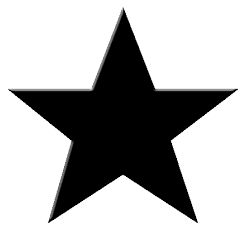

-----------harris-------------


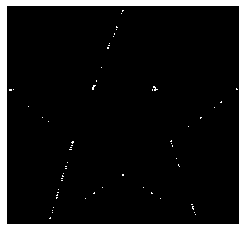

"\nprint('-----------susan-------------')\nresult = susan(m)\nc = np.squeeze(result)\nplt.imshow(c, cmap='gray'), plt.axis('off')\nplt.show()\n"

In [7]:
import matplotlib.pyplot as plt

#path = 'lena_grey.bmp'
path = 'temp.png'
m = Image.open(path)
plt.imshow(m,cmap='gray'), plt.axis('off')
plt.show()
'''
print('-----------moravec-------------')
result = moravec(m)
c = np.squeeze(result)
plt.imshow(c, cmap='gray'), plt.axis('off')
plt.show()
'''
print('-----------harris-------------')
result = harris(m)
c = np.squeeze(result)
plt.imshow(c, cmap='gray'), plt.axis('off')
plt.show()
'''
print('-----------susan-------------')
result = susan(m)
c = np.squeeze(result)
plt.imshow(c, cmap='gray'), plt.axis('off')
plt.show()
'''


In [87]:
# problem 1

import numpy as np
from PIL import Image
import copy

def generate_xfilter():
    _filter = [[-1,0,1],
               [-2,0,2],
               [-1,0,1]]
    _filter = np.array(_filter)
    return _filter

def generate_yfilter():
    _filter = [[-1,-2,-1],
               [0,0,0],
               [1,2,1]]
    _filter = np.array(_filter)
    return _filter

def edge_map(image_path):
    original_img = Image.open(image_path)
    original_img = np.array(original_img).astype('float32')
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
    
    
    array_shape = (original_img.shape[0]-2, original_img.shape[1]-2, original_img.shape[2])
    dx_map = np.zeros(shape = array_shape)
    dy_map = np.zeros(shape = array_shape)
    gradient_strength_map = np.zeros(shape = array_shape)
    gradient_orientation_map = np.zeros(shape = array_shape)
    xfilter = generate_xfilter()
    yfilter = generate_yfilter()
    for h in range(original_img.shape[0]-2):
        for w in range(original_img.shape[1]-2):
            for c in range(original_img.shape[2]):
                gradient_x = np.multiply(original_img[h:h+3,w:w+3,c],xfilter).sum()
                gradient_y = np.multiply(original_img[h:h+3,w:w+3,c],yfilter).sum()
                strength = (gradient_x**2 + gradient_y**2)**(1/2)
                
                orientation = (np.arctan(gradient_y/(gradient_x+1e-8))+np.pi/2)/np.pi*255.
                dx_map[h,w,c]=gradient_x
                dy_map[h,w,c]=gradient_y
                gradient_strength_map[h,w,c] = strength
                gradient_orientation_map[h,w,c] = orientation
    
    final_map = gradient_strength_map > 0
    
    return final_map

def solution(image):
    
    def check(cy,cx,img):
        d = [[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1]]
        n0 = img[cy+d[0][0],cx+d[0][1]]
        n1 = img[cy+d[1][0],cx+d[1][1]]
        n2 = img[cy+d[2][0],cx+d[2][1]]
        n3 = img[cy+d[3][0],cx+d[3][1]]
        n4 = img[cy+d[4][0],cx+d[4][1]]
        n5 = img[cy+d[5][0],cx+d[5][1]]
        n6 = img[cy+d[6][0],cx+d[6][1]]
        n7 = img[cy+d[7][0],cx+d[7][1]]
        
        if img[cy,cx]==1 and \
        ((not n0 and \
        (n4 and \
         (n5 or n6 or n2 or n3) and \
         (n6 or not n7) and \
         (n2 or not n1))) or \
         
         (not n4 and \
        (n0 and \
         (n1 or n2 or n6 or n7) and \
         (n2 or not n3) and \
         (n6 or not n5))) or \
         
         (not n2 and \
        (n6 and \
         (n7 or n0 or n4 or n5) and \
         (n0 or not n1) and \
         (n4 or not n3))) or \
         
         (not n6 and \
        (n2 and \
         (n3 or n4 or n0 or n1) and \
         (n4 or not n5) and \
         (n0 or not n7)))):
            return True
        return False
        '''
        if img[cy,cx]==1 and \
        ((n0 and \
        (not n4 and \
         (not n5 or not n6 or not n2 or not n3) and \
         (not n6 or n7) and \
         (not n2 or n1))) or \
         
         (n4 and \
        (not n0 and \
         (not n1 or not n2 or not n6 or not n7) and \
         (not n2 or n3) and \
         (not n6 or n5))) or \
         
         (n2 and \
        (not n6 and \
         (not n7 or not n0 or not n4 or not n5) and \
         (not n0 or n1) and \
         (not n4 or n3))) or \
         
         (n6 and \
        (not n2 and \
         (not n3 or not n4 or not n0 or not n1) and \
         (not n4 or n5) and \
         (not n0 or n7)))):
            return True
        return False
        '''
    
    M,N = image.shape
    result = copy.deepcopy(image)
    out=copy.deepcopy(result)
    while True:
        for j in range(1,M-2):
            for i in range(1,N-2):
                if check(j,i,result):
                    result[j,i]=0
                else:
                    result[j,1]=1
        
        if (out==result).all():
            break
        out=copy.deepcopy(result)
        
    return result


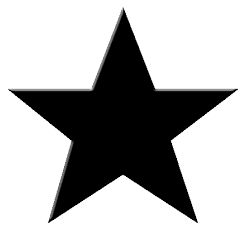

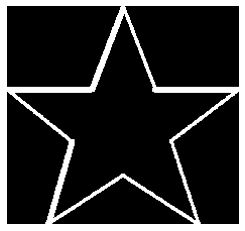

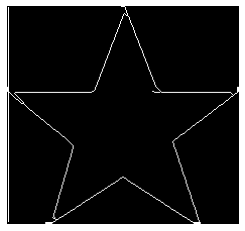

In [88]:
import matplotlib.pyplot as plt

#path = 'lena_grey.bmp'
path = 'temp.png'
m = Image.open(path)
plt.imshow(m,cmap='gray'), plt.axis('off')
plt.show()

final_map = edge_map(path)
c = np.squeeze(final_map)
m = Image.fromarray(c)
plt.imshow(m, cmap='gray'), plt.axis('off')
plt.show()

final_map = final_map.squeeze()
result = solution(final_map)
c = np.squeeze(result)
m = Image.fromarray(c)
plt.imshow(m, cmap='gray'), plt.axis('off')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def gaussian(k,mean = 0, std=1):
    if k%2==0:
        raise Exception('짝수 X')
    size = (k,k)
    gauss_filter = np.zeros(size)
    mid = (k-1)//2
    
    # mean = 0 이라 가정
    
    for i in range(k):
        for j in range(k):
            gauss_filter[i,j] = np.exp(-((((i-mid)**2) + ((j-mid)**2))/(2*(std**2))))
    K = gauss_filter.sum()
    
    return gauss_filter/K

def solution(image):
    
    #original_img = np.array(image).astype('float32')
    original_img = np.array(image)
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
    k=3    
    series = 6
    height, width, channel = original_img.shape
    original_img = np.pad(original_img, (((k-1)//2,(k-1)//2),((k-1)//2,(k-1)//2),(0,0)), 'constant', constant_values=0)
    difference_map = np.zeros(shape=(series, height, width, channel))
    #for s, sigma in enumerate([1.6,2.01,2.53,3.2,4.03,5.08]):
    sigma = 1.6
    for s in range(0,6):
        _filter = gaussian(k=k, std = sigma*(np.cbrt(2))**s)
        print(sigma*(np.cbrt(2))**s)
        _filter = np.expand_dims(_filter,2)
        for i in range(height):
                for j in range(width):
                    for c in range(channel):
                        difference_map[s,i,j,c]=np.multiply(original_img[i:i+k,j:j+k,c], _filter[:,:,c]).sum()
    result=[]
    for s in range(difference_map.shape[0]-1,-1,-1):
        result.append(difference_map[s]-difference_map[s-1])
    return result

def downsampling(image,ratio):
    #original_img = np.array(image).astype('float32')
    original_img = np.array(image)
    if len(original_img.shape)==2:
        original_img = np.expand_dims(original_img,2)
    height, width, channel = original_img.shape
    
    result_img = np.zeros(shape=(int(height*ratio), int(width*ratio), channel))
    result_height, result_width, _ = result_img.shape
    for h in range(result_height):
        for w in range(result_width):
            for c in range(channel):
                result_img[h,w,c] = original_img[int(h/(ratio+1e-8)),int(w/(ratio+1e-8)),c]
    return result_img

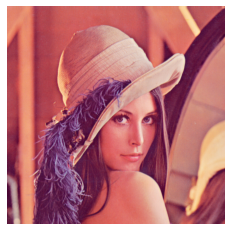

1.6


IndexError: index 1 is out of bounds for axis 2 with size 1

In [2]:
import matplotlib.pyplot as plt

path = 'lena_grey.bmp'
m = Image.open(path)
plt.imshow(m,cmap='gray'), plt.axis('off')
plt.show()



result = solution(m)
for re in result:
    #c = np.squeeze(np.abs(re)*255.)
    c = np.squeeze(re)
    plt.imshow(c, cmap='gray'), plt.axis('off')
    plt.show()
    
    

downsample = downsampling(m,0.8)
print(downsample.shape)
result = solution(downsample)
for re in result:
    c = np.squeeze(re)
    plt.imshow(c, cmap='gray'), plt.axis('off')
    plt.show()


In [26]:
a1 = [[3,1],[2,-1]]
a1 = np.array(a1)
a2 = np.linalg.inv(a1)
l = np.array([[4,0],[0,-1]])
a1.dot(l).dot(a2)

array([[2., 3.],
       [2., 1.]])

In [29]:
a = np.array([[3,2,2],[2,3,-2]])
b = a.T
b.dot(a)

array([[13, 12,  2],
       [12, 13, -2],
       [ 2, -2,  8]])

In [42]:
a = np.array([[3,2,2],[2,3,-2]])
at = a.T
aat = a.dot(at)
ata = at.dot(a)
np.linalg.eig(ata)[1].T


array([[-7.07106781e-01, -7.07106781e-01, -1.16614446e-17],
       [-6.66666667e-01,  6.66666667e-01,  3.33333333e-01],
       [ 2.35702260e-01, -2.35702260e-01,  9.42809042e-01]])

In [38]:
at

array([[3, 5],
       [7, 2]])